In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from graspy.utils import * 
from graspy.plot import heatmap, pairplot, gridplot
from graspy.embed import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspy.utils import import_graph, pass_to_ranks


def _check_common_inputs(figsize=None,
                         height=None,
                         title=None,
                         context=None,
                         font_scale=None,
                         legend_name=None):
    # Handle figsize
    if figsize is not None:
        if not isinstance(figsize, tuple):
            msg = 'figsize must be a tuple, not {}.'.format(type(figsize))
            raise TypeError(msg)

    # Handle heights
    if height is not None:
        if not isinstance(height, (int, float)):
            msg = 'height must be an integer or float, not {}.'.format(
                type(height))
            raise TypeError(msg)

    # Handle title
    if title is not None:
        if not isinstance(title, str):
            msg = 'title must be a string, not {}.'.format(type(title))
            raise TypeError(msg)

    # Handle context
    if context is not None:
        if not isinstance(context, str):
            msg = 'context must be a string, not {}.'.format(type(context))
            raise TypeError(msg)
        elif not context in ['paper', 'notebook', 'talk', 'poster']:
            msg = 'context must be one of (paper, notebook, talk, poster), \
                not {}.'.format(context)
            raise ValueError(msg)

    # Handle font_scale
    if font_scale is not None:
        if not isinstance(font_scale, (int, float)):
            msg = 'font_scale must be an integer or float, not {}.'.format(
                type(font_scale))
            raise TypeError(msg)

    # Handle legend name
    if legend_name is not None:
        if not isinstance(legend_name, str):
            msg = 'legend_name must be a string, not {}.'.format(
                type(legend_name))
            raise TypeError(msg)


def _transform(arr, method):
    if method is not None:
        if method == 'log':
            #arr = np.log(arr, where=(arr > 0))
            #hacky, but np.log(arr, where=arr>0) is really buggy
            arr = arr.copy()
            arr[arr > 0] = np.log(arr[arr > 0])
        elif method in ['zero-boost', 'simple-all', 'simple-nonzero']:
            arr = pass_to_ranks(arr, method=method)
        else:
            msg = 'Transform must be one of {log, zero-boost, simple-all, \
            simple-nonzero, not {}.'.format(method)
            raise ValueError(msg)

    return arr

def gridplot(X,
             labels,
             transform=None,
             height=10,
             title=None,
             context='talk',
             font_scale=1,
             alpha=0.7,
             sizes=(10, 200), 
             palette=None):
    r"""
    Plots multiple graphs as a grid, with intensity denoted by the size 
    of dots on the grid.
    Parameters
    ----------
    X : list of nx.Graph or np.ndarray object
        List of nx.Graph or numpy arrays to plot
    labels : list of str
        List of strings, which are labels for each element in X. 
        `len(X) == len(labels)`.
    transform : None, or string {'log', 'zero-boost', 'simple-all', 'simple-nonzero'}
        - 'log' :
            Plots the log of all nonzero numbers
        - 'zero-boost' :
            Pass to ranks method. preserves the edge weight for all 0s, but ranks 
            the other edges as if the ranks of all 0 edges has been assigned. 
        - 'simple-all': 
            Pass to ranks method. Assigns ranks to all non-zero edges, settling 
            ties using the average. Ranks are then scaled by 
            :math:`\frac{2 rank(\text{non-zero edges})}{n^2 + 1}` 
            where n is the number of nodes
        - 'simple-nonzero':
            Pass to ranks method. Aame as simple-all, but ranks are scaled by
            :math:`\frac{2 rank(\text{non-zero edges})}{\text{total non-zero edges} + 1}`
    height : int, optional, default: 10
        Height of figure in inches.
    title : str, optional, default: None
        Title of plot.
    context :  None, or one of {paper, notebook, talk (default), poster}
        The name of a preconfigured set.
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    """
    _check_common_inputs(
        height=height, title=title, context=context, font_scale=font_scale)

    if isinstance(X, list):
        graphs = [import_graph(x) for x in X]
    else:
        msg = 'X must be a list, not {}.'.format(type(X))
        raise TypeError(msg)

    # Handle labels
    if not isinstance(labels, list):
        msg = 'labels must be a list, not {}.'.format(type(labels))
        raise TypeError(msg)
    elif len(labels) != len(graphs):
        msg = 'Expected {} elements in labels, but got {} instead.'.format(
            len(graphs), len(labels))
        raise ValueError(msg)

    graphs = [_transform(arr, transform) for arr in graphs]
    
    if palette is None:
        palette = sns.color_palette('Set1', desat=0.75, n_colors=len(labels))

    dfs = []
    for idx, graph in enumerate(graphs):
        rdx, cdx = np.where(graph > 0)
        weights = graph[(rdx, cdx)]
        df = pd.DataFrame(
            np.vstack([rdx, cdx, weights]).T,
            columns=['rdx', 'cdx', 'Weights'])
        df['Type'] = [labels[idx]] * len(cdx)
        dfs.append(df)

    df = pd.concat(dfs, axis=0)

    with sns.plotting_context(context, font_scale=font_scale):
        sns.set_style('white')
        plot = sns.relplot(
            data=df,
            x='cdx',
            y='rdx',
            hue='Type',
            size='Weights',
            sizes=sizes,
            alpha=alpha,
            palette=palette,
            height=height,
            facet_kws={
                'sharex': True,
                'sharey': True,
                'xlim': (0, graph.shape[0]),
                'ylim': (0, graph.shape[0]),
            })
        plot.ax.axis('off')
        plot.ax.invert_yaxis()
        if title is not None:
            plot.set(title=title)
        plot.ax.xaxis.set_label_position('top') 
        plot.ax.xaxis.tick_top()
        
    return plot


In [3]:
data_path = Path('/Users/bpedigo/JHU_code/elegans/nice_data')
cell_info_file = data_path / 'herm_cell_data.csv'
cell_df = pd.read_csv(cell_info_file)
cell_df = cell_df.set_index('name')

data_names = [
    'herm_chem_A_full.csv',
    'herm_chem_A_self.csv',
    'herm_chem_A_full_undirected.csv',
    'herm_chem_A_self_undirected.csv',
    'herm_chem_A_multi.csv',
    'male_chem_A_full.csv',
    'male_chem_A_self.csv',
    'male_chem_A_full_undirected.csv',
    'male_chem_A_self_undirected.csv',
    'male_chem_A_multi.csv'
]

loaded = []
[loaded.append(np.loadtxt(data_path / d, delimiter=',')) for d in data_names]

herm_chem_A_full = loaded[0]
herm_chem_A_self = loaded[1]
herm_chem_A_full_undirected = loaded[2]
herm_chem_A_self_undirected = loaded[3]
herm_chem_A_multi = loaded[4]
male_chem_A_full = loaded[5]
male_chem_A_self = loaded[6]
male_chem_A_full_undirected = loaded[7]
male_chem_A_self_undirected = loaded[8]
male_chem_A_multi = loaded[9]

data_names = [
    'shared_chem_cells.csv'
]
loaded = []
[loaded.append(np.loadtxt(data_path / d, dtype='str')) for d in data_names]
shared_cells = loaded[0]


In [6]:
shared_cells_df = cell_df.loc[shared_cells]
shared_cells_df_sorted.sort_values(by=['hemisphere', 'type1'], kind='mergesort', inplace=True)

type1 = shared_cells_df_sorted['type1'].values
hemisphere = shared_cells_df_sorted['hemisphere'].values

type1_unique = np.unique(type1)
type1_freq = np.array([])

hemisphere_unique, hemisphere_freq = np.unique(hemisphere, return_counts=True)
hemisphere_freq_cumsum = np.hstack([0, hemisphere_freq.cumsum()])

for idx in range(hemisphere_freq.size):
#     print(hemisphere_freq_cumsum[idx], hemisphere_freq_cumsum[idx+1])
    _, temp_freq = np.unique(type1[hemisphere_freq_cumsum[idx]:hemisphere_freq_cumsum[idx+1]], return_counts=True)
    type1_freq = np.hstack([type1_freq, temp_freq])

type1_freq_cumsum = np.hstack([0, type1_freq.cumsum()])

0 108
108 266
266 426


In [7]:
cell_idx = list(shared_cells_df_sorted.index)

sorted_idx = np.array([list(shared_cells).index(i) for i in cell_idx])

herm_chem_A_multi_ordered = herm_chem_A_multi[sorted_idx, :][:, sorted_idx]
male_chem_A_multi_ordered = male_chem_A_multi[sorted_idx, :][:, sorted_idx]

h_nonzero = np.nonzero(herm_chem_A_multi_ordered > 0)
m_nonzero = np.nonzero(male_chem_A_multi_ordered > 0)
h_nonzero = set(zip(*h_nonzero))
m_nonzero = set(zip(*m_nonzero))
both_inds = h_nonzero.intersection(m_nonzero)
list(both_inds)[-1]
both_mat = np.zeros_like(herm_chem_A_multi_ordered)
for point in both_inds:
    r, c = point
    val = max(herm_chem_A_multi_ordered[point], male_chem_A_multi_ordered[point])
    both_mat[point] = val
both_mat[list(zip(*both_inds))]


/Users/bpedigo/JHU_code/graspy/graspy-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


array([ 2.,  8.,  7., ...,  2., 10., 21.])

[Text(0, 0, 'B'), Text(0, 0, 'L'), Text(0, 0, 'R')]

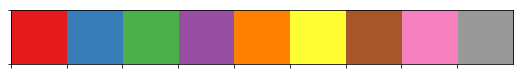

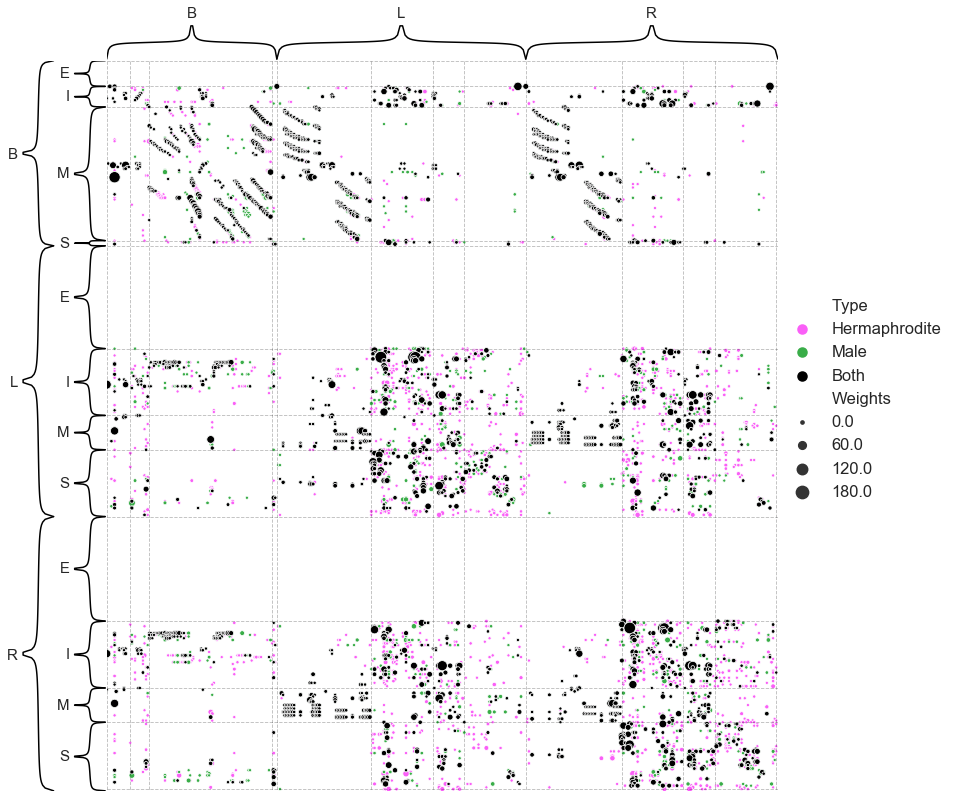

In [8]:
magenta = sns.xkcd_rgb["light magenta"]
green = sns.xkcd_rgb["medium green"]#'medium green'# sns.color_palette('Set1')[2]#'#00FF00'
black = '#000000'
sns.palplot(sns.color_palette('Set1'))
orange = sns.xkcd_rgb["orange"]
sky_blue = sns.xkcd_rgb["sky blue"]
my_palette = sns.color_palette([magenta, green, black])
# my_palette = sns.color_palette([orange, sky_blue, black])
g = gridplot([herm_chem_A_multi_ordered, male_chem_A_multi_ordered, both_mat],
         labels=['Hermaphrodite', 'Male', 'Both'],
         font_scale=1, 
         sizes=(10,150),
         alpha=1,
         height=12,
         palette=my_palette)

         
ax = g.ax

# draw lines for separating blocks
# need to do this first
for x in type1_freq_cumsum:
    if x == type1_freq_cumsum[-1]:
        x -= 1
    ax.vlines(x, 0, 426, linestyle='dashed', lw=.9, alpha=.25, zorder=3)
    ax.hlines(x, 0, 426, linestyle='dashed', lw=.9, alpha=.25, zorder=3)
    
# horizontal curve
tick_loc = hemisphere_freq.cumsum() - hemisphere_freq / 2
tick_width = hemisphere_freq / 2

divider= make_axes_locatable(ax)
ax_x = divider.new_vertical(size="5%", pad=0.0, sharex=ax, pack_start=False)
ax.figure.add_axes(ax_x)

# make curve
lx = np.linspace(-np.pi/2.+0.05, np.pi/2.-0.05, 50)
tan = np.tan(lx)
curve = np.hstack((tan[::-1],tan))

for x0, width in zip(tick_loc, tick_width):
    x = np.linspace(x0 - width, x0 + width, 100)
    ax_x.plot(x, -curve, c='k')
    
ax_x.set_yticks([])
ax_x.tick_params(axis='x', which=u'both',length=0)
for direction in ["left", "right", "bottom", "top"]:
    ax_x.spines[direction].set_visible(False)
ax_x.set_xticks(tick_loc)
ax_x.set_xticklabels(['B', 'L', 'R'], fontsize=15)

ax_x.xaxis.set_label_position('top')
ax_x.xaxis.tick_top()

# vertical curves
tick_loc = type1_freq.cumsum() - type1_freq / 2
tick_width = type1_freq / 2

ax_y = divider.new_horizontal(size="5%", pad=0.0, sharey=ax, pack_start=True)
ax.figure.add_axes(ax_y)

for x0, width in zip(tick_loc, tick_width):
    x = np.linspace(x0 - width, x0 + width, 100)
    ax_y.plot(curve, x, c='k')
    
ax_y.set_xticks([])
ax_y.tick_params(axis='y', which=u'both',length=0)
for direction in ["left", "right", "bottom", "top"]:
    ax_y.spines[direction].set_visible(False)
ax_y.set_yticks(tick_loc)
ax_y.set_yticklabels(np.tile(['E', 'I', 'M', 'S'], 3), fontsize=15, verticalalignment='center')

#ax_x.set_xlabel('Hemisphere', fontsize=20)
#ax_y.set_ylabel('Cell Type', fontsize=20)

# outer y-axis curves
tick_loc = hemisphere_freq.cumsum() - hemisphere_freq / 2
tick_width = hemisphere_freq / 2

ax_y2 = divider.new_horizontal(size="5%", pad=.25, pack_start=True)
ax.figure.add_axes(ax_y2)

for x0, width in zip(tick_loc, tick_width):
    x = np.linspace(x0 - width, x0 + width, 100)
    ax_y2.plot(curve, x, c='k')

ax_y2.set_xticks([])
ax_y2.tick_params(axis='y', which=u'both',length=0) #cannot sharey cause they then share labels
ax_y2.set_ylim(0, herm_chem_A_multi_ordered.shape[0]) #need to set range manually
ax_y2.invert_yaxis() # origin at top left corner
for direction in ["left", "right", "bottom", "top"]:
    ax_y2.spines[direction].set_visible(False)
ax_y2.set_yticks(tick_loc)
ax_y2.set_yticklabels(['B', 'L', 'R'], fontsize=15)